<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Handmade" data-toc-modified-id="Handmade-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Handmade</a></span></li><li><span><a href="#Embeddings" data-toc-modified-id="Embeddings-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Embeddings</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [5]:
from pytorch_metric_learning import losses, miners, distances, reducers, samplers
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn
import random
from pytorch_tabnet.tab_network import TabNet

In [6]:
from code.dataloader_handmade import AgeGroupHandmadeDataset
from code.encoder_tabnet import Encoder
from code.decoder import Decoder
from code.classifier import Classifier
from code.utils import train_ml_model, train_classifier, train_tabnet

In [7]:
BATCH_SIZE = 64 # BATCH_SIZE unique persons
NUM_OF_SUBSEQUENCES = 5
SUBSEQUENCE_LENGTH = 90

EMBEDDING_DIM = 10
LR = 0.002
NUM_EPOCHS = 10

cat_vocab_sizes = [204]
cat_embedding_dim = 20
num_input_dim = 4
NUM_OBS = 30000
SCHEDULER_EPOCHS = 2

In [8]:
dataset = AgeGroupHandmadeDataset()

In [9]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [10]:
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    num_workers=0,
)

targets = dataset.y

train_idx, test_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    shuffle=True,
    stratify=targets,
    random_state=228
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    sampler=train_sampler)
testloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    sampler=test_sampler)

##  Handmade

In [ ]:
from code.classifier_tabnet import Classifier

In [ ]:
clf = Classifier(
    input_dim=dataset.X.shape[1],
    embedding_dim=EMBEDDING_DIM,
    out_dim=4,
)

In [ ]:
clf.to(device);

In [ ]:
NUM_EPOCHS = 30
LR = 0.02

In [ ]:
optimizer = optim.Adam(clf.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=SCHEDULER_EPOCHS,
)

In [ ]:
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

In [ ]:
for epoch in tqdm(range(NUM_EPOCHS)):
    clf.train()
    correct = 0
    total = 0
    epoch_losses = []
    for (sequences, labels) in trainloader:
        sequences = sequences.to(device)
        labels = labels.to(device)

        outputs = clf(sequences)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 0.3)
        optimizer.step()

        pred_labels = torch.argmax(outputs, dim=1)
        correct += sum(labels == pred_labels)
        total += len(sequences)
        epoch_losses.append(loss.item())

    train_acc = correct / total
    epoch_loss = torch.tensor(epoch_losses).mean()
    train_losses.append(epoch_loss)
    train_accuracy.append(train_acc.item())

    clf.eval()
    correct = 0
    total = 0
    epoch_val_losses = []
    for sequences, labels in testloader:
        sequences = sequences.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = clf(sequences)
            loss = criterion(outputs, labels)

            pred_labels = torch.argmax(outputs, dim=1)
            correct += sum(labels == pred_labels)
            total += len(sequences)
            epoch_val_losses.append(loss.item())

    val_acc = correct / total
    epoch_val_loss = torch.tensor(epoch_val_losses).mean()
    val_losses.append(epoch_val_loss)
    val_accuracy.append(val_acc.item())

    scheduler.step(epoch_val_loss)

    print(f'Epoch {epoch}, train acc: {train_acc}, val acc: {val_acc}')
    print(f'train loss: {epoch_loss}; val loss: {epoch_val_loss}')

In [ ]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('iter')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('iter')
plt.ylabel('accuracy');
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='validation')
plt.legend()

plt.savefig(f'plots/tabnet_handmade_{EMBEDDING_DIM}_{NUM_EPOCHS}.png')

In [ ]:
val_accuracy[-1]

## Embeddings

In [18]:
from code.dataloader import AgeGroupMLDataset, AgeGroupClfDataset
from code.encoder_gru import Encoder
from code.classifier_tabnet import Classifier
from code.utils import train_ml_model, train_classifier

In [22]:
BATCH_SIZE = 64 # BATCH_SIZE unique persons
NUM_OF_SUBSEQUENCES = 5
SUBSEQUENCE_LENGTH = 90

EMBEDDING_DIM = 256
LR = 0.002
NUM_EPOCHS = 20

cat_vocab_sizes = [204]
cat_embedding_dim = 20
num_input_dim = 4
NUM_OBS = 30000
SCHEDULER_EPOCHS = 2

In [13]:
dataset = AgeGroupMLDataset(num_observations=NUM_OBS)

In [14]:
dataset.load_client_to_indices()

In [15]:
clfdataset = AgeGroupClfDataset()

In [16]:
clfdataset.load_client_to_indices()

In [17]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [23]:
targets = dataset.targets

dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    num_workers=0,
)

targets = clfdataset.targets

train_idx, test_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    shuffle=True,
    stratify=targets,
    random_state=228
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=train_sampler)
testloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=test_sampler)

In [24]:
encoder = Encoder(
    numerical_input_dim=num_input_dim,
    cat_vocab_sizes=cat_vocab_sizes,
    cat_embedding_dim=cat_embedding_dim,
    embedding_dim=EMBEDDING_DIM,
)
encoder.to(device);
optimizer = optim.Adam(encoder.parameters(), lr=LR)

distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
loss_func = losses.TripletMarginLoss(margin = 0.4, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.4, distance = distance, type_of_triplets = "semihard")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss = 0.18814076483249664
Epoch 1 Loss = 0.15974928438663483
Epoch 2 Loss = 0.15075694024562836
Epoch 3 Loss = 0.14774274826049805
Epoch 4 Loss = 0.14597676694393158
Epoch 5 Loss = 0.1448737531900406
Epoch 6 Loss = 0.14377163350582123
Epoch 7 Loss = 0.14267662167549133
Epoch 8 Loss = 0.14215195178985596
Epoch 9 Loss = 0.14124317467212677
Epoch 10 Loss = 0.14108020067214966
Epoch 11 Loss = 0.1402079164981842
Epoch 12 Loss = 0.1396324187517166
Epoch 13 Loss = 0.139360249042511
Epoch 14 Loss = 0.13896039128303528
Epoch 15 Loss = 0.13913142681121826
Epoch 16 Loss = 0.13836294412612915
Epoch 17 Loss = 0.13816387951374054
Epoch 18 Loss = 0.1376878321170807
Epoch 19 Loss = 0.13795436918735504


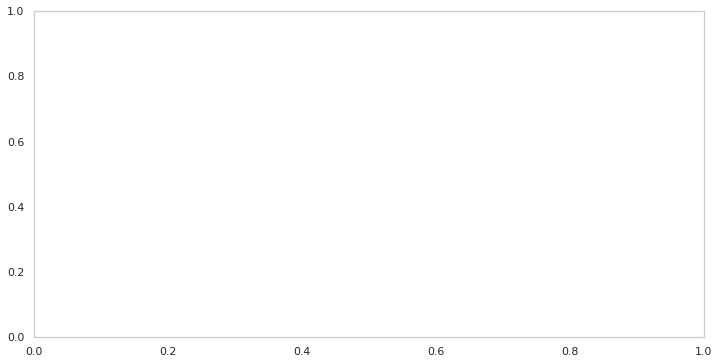

In [25]:
train_losses = train_ml_model(
    encoder, NUM_EPOCHS, dataloader, NUM_OF_SUBSEQUENCES,
    mining_func, loss_func, optimizer)

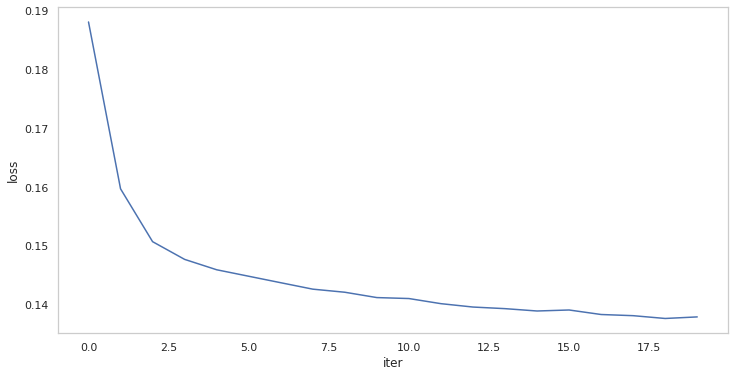

In [27]:
fig, axs = plt.subplots(figsize=(12, 6))
plt.plot(train_losses, label='train')
plt.xlabel('iter')
plt.ylabel('loss');

In [28]:
encoder.eval();

In [29]:
for param in encoder.parameters():
    param.requires_grad = False

In [103]:
clf = Classifier(
    input_dim=EMBEDDING_DIM,
    embedding_dim=EMBEDDING_DIM,
    out_dim=4,
)

In [104]:
clf.to(device);

In [105]:
NUM_EPOCHS = 60
LR = 0.02

In [106]:
optimizer = optim.Adam(clf.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=SCHEDULER_EPOCHS,
)

In [107]:
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

In [108]:
for epoch in tqdm(range(NUM_EPOCHS)):
    clf.train()
    correct = 0
    total = 0
    epoch_losses = []
    for (sequences, labels) in trainloader:
        n, c = sequences[0], sequences[1]
        n = n.to(device)
        c = c.to(device)
        labels = labels.to(device)
        
        outputs = encoder(n, c)
        outputs = clf(outputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(clf.parameters(), 100)
        optimizer.step()

        pred_labels = torch.argmax(outputs, dim=1)
        correct += sum(labels == pred_labels)
        total += len(n)
        epoch_losses.append(loss.item())

    train_acc = correct / total
    epoch_loss = torch.tensor(epoch_losses).mean()
    train_losses.append(epoch_loss)
    train_accuracy.append(train_acc.item())

    clf.eval()
    correct = 0
    total = 0
    epoch_val_losses = []
    for sequences, labels in testloader:
        n, c = sequences[0], sequences[1]
        n = n.to(device)
        c = c.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = encoder(n, c)
            outputs = clf(outputs)
            loss = criterion(outputs, labels)

            pred_labels = torch.argmax(outputs, dim=1)
            correct += sum(labels == pred_labels)
            total += len(n)
            epoch_val_losses.append(loss.item())

    val_acc = correct / total
    epoch_val_loss = torch.tensor(epoch_val_losses).mean()
    val_losses.append(epoch_val_loss)
    val_accuracy.append(val_acc.item())

    scheduler.step(epoch_val_loss)

    print(f'Epoch {epoch}, train acc: {train_acc}, val acc: {val_acc}')
    print(f'train loss: {epoch_loss}; val loss: {epoch_val_loss}')

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 0, train acc: 0.34638094902038574, val acc: 0.33399999141693115
train loss: 1.5555222034454346; val loss: 1.326651930809021
Epoch 1, train acc: 0.43285712599754333, val acc: 0.4072222411632538
train loss: 1.2139785289764404; val loss: 1.2080248594284058
Epoch 2, train acc: 0.442809522151947, val acc: 0.4740000069141388
train loss: 1.1872402429580688; val loss: 1.1294655799865723
Epoch 3, train acc: 0.46666666865348816, val acc: 0.48044446110725403
train loss: 1.1497089862823486; val loss: 1.1194477081298828
Epoch 4, train acc: 0.46971428394317627, val acc: 0.47822222113609314
train loss: 1.1432878971099854; val loss: 1.1258232593536377
Epoch 5, train acc: 0.47371429204940796, val acc: 0.47911110520362854
train loss: 1.1381678581237793; val loss: 1.1238540410995483
Epoch 6, train acc: 0.4789523780345917, val acc: 0.49044445157051086
train loss: 1.1238553524017334; val loss: 1.1124531030654907
Epoch 7, train acc: 0.4850476086139679, val acc: 0.47777777910232544
train loss: 1.119143

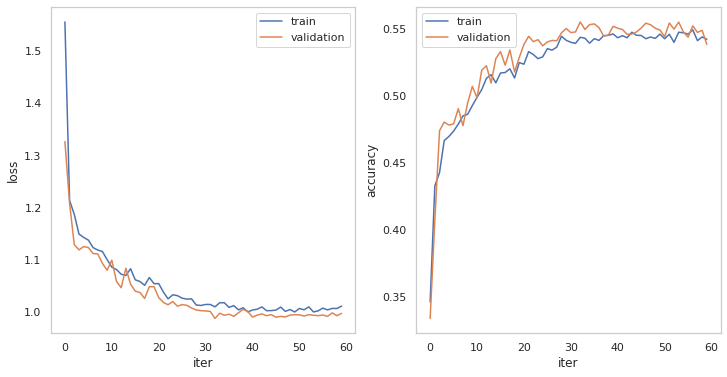

In [109]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('iter')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.xlabel('iter')
plt.ylabel('accuracy');
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='validation')
plt.legend()

plt.savefig(f'plots/tabnet_decoder_{EMBEDDING_DIM}_{NUM_EPOCHS}.png')